#EE-411, HomeWork 3 : Neural networks
Submission for Culha Defne (SCIPER 353020)

EPFL, Autumn 2022




##Part 1: Backpropagation with logistic loss

###1 Predict function

In [1]:
# Sigmoid function
def sigmoid(t):
    """apply sigmoid function on t."""
    return 1.0 / (1 + np.exp(-t))

# Gradient of sigmoid function
def grad_sigmoid(t):
    """return the derivative of sigmoid on t."""
    return sigmoid(t) * (1 - sigmoid(t))


In [2]:
# Forward pass predict
def predict(X, W):
    x_0 = X
    z_1 = W["w_1"].T @ x_0
    x_1 = sigmoid(z_1)
    z_2 = W["w_2"].T @ x_1
    y_hat = sigmoid(z_2)
    
    return z_1, z_2, y_hat

###2 Logistic loss

In [3]:
import numpy as np

# Logistic loss function
def logistic_loss(y, y_hat):
  y_mean = np.mean(y)
  y_hat_mean = np.mean(y_hat)
  loss = np.mean( -y*np.log(y_hat) - (1-y)*np.log(1-y_hat))
  return loss


In [4]:
logistic_loss(0, 0)

<ipython-input-3-f559b6df641c>:7: RuntimeWarning: divide by zero encountered in log
  loss = np.mean( -y*np.log(y_hat) - (1-y)*np.log(1-y_hat))
<ipython-input-3-f559b6df641c>:7: RuntimeWarning: invalid value encountered in double_scalars
  loss = np.mean( -y*np.log(y_hat) - (1-y)*np.log(1-y_hat))


nan

The result when for the case yˆ = 0 and y = 0 is nan since log function is inputted a 0 for which it's undefined.

### 3 Stable logistic loss

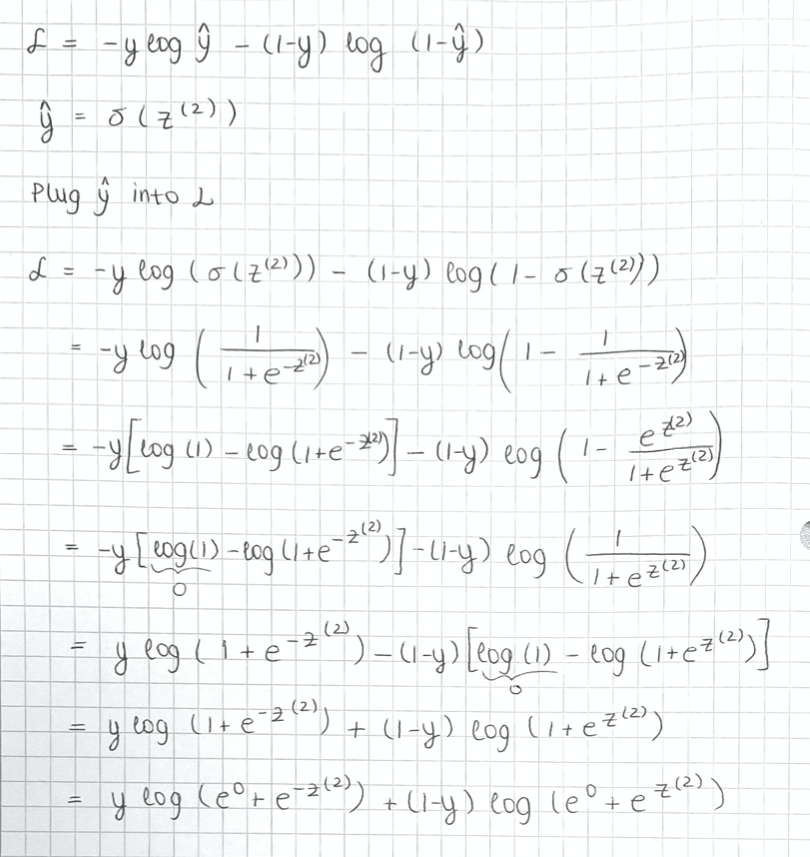

In [5]:
# Logistic loss function but use z_2 instead of y_hat for stability
# See the derivation above
def stable_logistic_loss(y, z_2):
  loss = -y*z_2 + np.logaddexp(0,z_2)
  loss = y*np.logaddexp(0,-z_2)+(1-y)*np.logaddexp(0,z_2)
  return loss.mean()


In [6]:
z_2 = -10**10
stable_logistic_loss(0, z_2)
print('When y=0 and z_2 = -10**10 stable logistic loss is', stable_logistic_loss(0, z_2))

When y=0 and z_2 = -10**10 stable logistic loss is 0.0


Average loss for the case when z_2 = −10^10 and y = 0 is computed as 0. Now, a value is returned. This is because the calculated values are so small as to exceed the range of normal floating point numbers. With the addlogexp in stable version, we store the logarithm of the numbers and add them. So now, a value is returned instead of nan since the value inside logarithm function is non-zero.

###4 Derive analytically, using the backpropagation algorithm, the expressions for the partial derivatives of the loss with respect to the weights

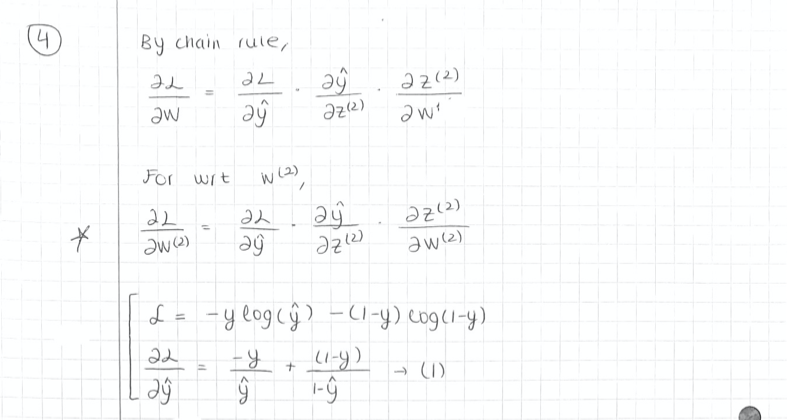

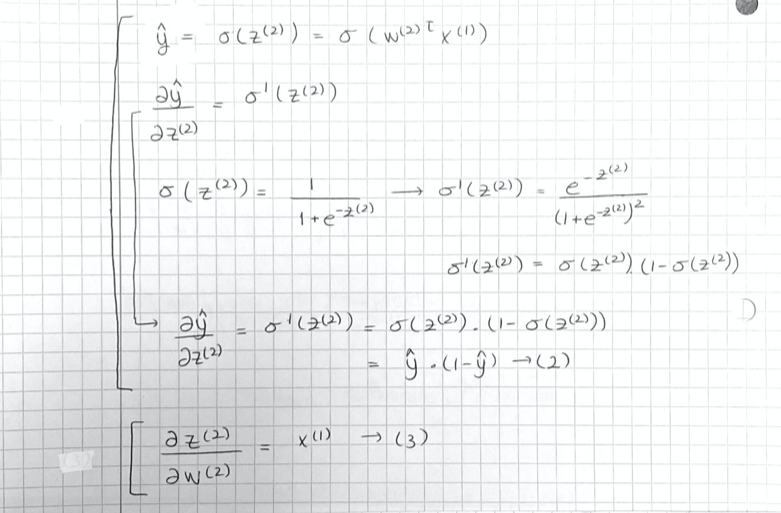

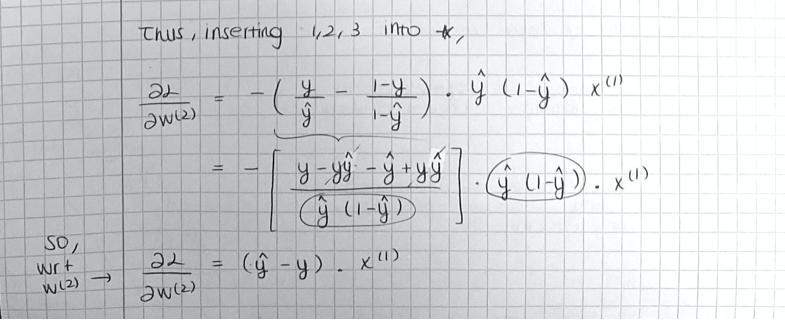

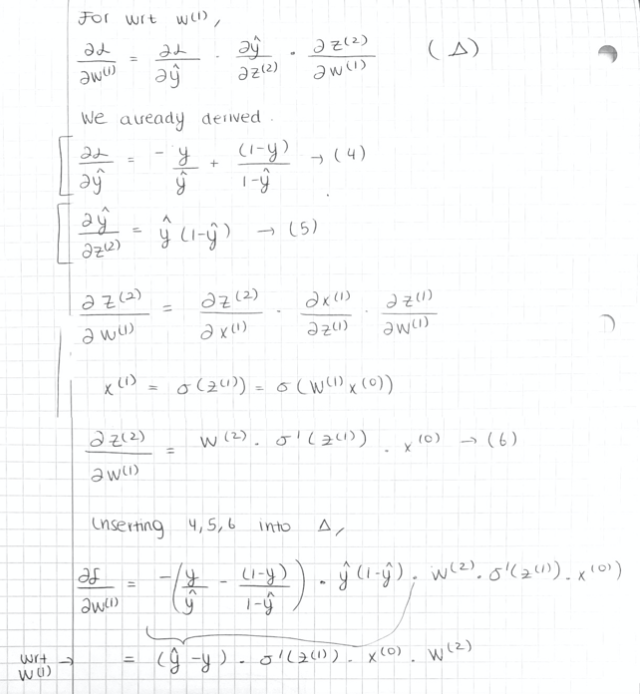

### 5 Gradient function

In [7]:
# Backpropogation to get gradients of loss wrt weight
def gradient(X, y, W):
    """Do backpropagation and get delta_W."""
    # Feed forward predict to get variables
    x_0 = X
    z_1, z_2, y_hat = predict(X, W)
    x_1 = sigmoid(z_1)
    
    # Backpropogation to get gradients
    
    # wrt w_2
    delta_2 = (y_hat - y) 
    delta_w_2 = delta_2 * x_1

    # wrt w_1
    delta_1 = W["w_2"].T@(grad_sigmoid(z_1)@(y_hat-y).T)
    delta_w_1 = np.outer(x_0, delta_1)

    return {
        "w_2": delta_w_2,
        "w_1": delta_w_1
    }

##Part 2: Classifying FashionMNIST using neural networks

###1 Loading the dataset and constructing the dataloaders

Load the dataset and construct the dataloaders for train, validation and test, and visualize the data. Use an 50000 and 10000 images for train and validation, respectively. We need to transform our data to a type that is readable by a Neural Network. Thus, we use the ToTensor() "transform". 

In [8]:
# first we load all the necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader



In [9]:
# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform" 
transform = T.Compose([
    T.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

print(train_dataset)

# Split the training set into training + validation. 
# How many samples does the training set have?
print(f"The training set has {len(train_dataset)} samples.")

# Split the dataset into ?????-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset, 
    lengths=[50000, 10000], 
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
The training set has 60000 samples.


In [10]:

# define the hyperparameters
BATCH_SIZE = 50
TEST_BATCH_SIZE = 10
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)


cuda


In [11]:

train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)



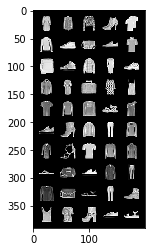

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first 50 000 images of the train dataset. Hint: use next(), iter()
images = next(iter(train_dataloader))[0][:50000]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)


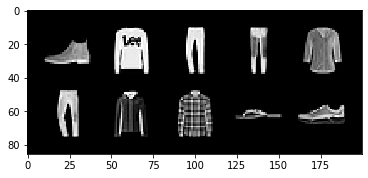

In [13]:
# Get the first 10 000 images of the validation dataset. Hint: use next(), iter()
images = next(iter(test_dataloader))[0][:10000]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)


###2 MultiLayer Perceptron (MLP) 

Construct a two-hidden-layer MLP with 100 neurons (per layer), ReLU activation functions and a linear output layer to classify FashionMNIST.

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        # define the different modules of the network
        super().__init__()
        # How many features should our model have?
        self.fc1 = nn.Linear(28*28, 100)


        self.fc2 = nn.Linear(100, 100)

        # How many outputs should our model have?
        self.fc3 = nn.Linear(100, 10)
        # we also define the non-linearity 
        self.relu = nn.ReLU()



    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ***************************************************
        # INSERT YOUR CODE HERE
        # You should (a) transform the a size that is readable
        # by the MLP and (b) pass the the input x successively 
        # through the layers.
        # ***************************************************
        # transform the image to a vector
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        # pass the vectored image through the layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


In [15]:
# initialize the model
model = Net()

# move model to device
model = model.to(DEVICE)

Train this model for 20 epochs using the cross-entropy loss and the following optimizers : SGD (lr=0.01), SGD with momentum (lr=0.01, momentum=0.9, nesterov=True), Adam (lr=0.01) and Adam (lr=1). 

In [16]:
# initialize the model
model = Net()

# move model to device
model = model.to(DEVICE)

# define the optimizer
# Hint: https://pytorch.org/docs/stable/optim.html
optimizer_SGD = optim.SGD(model.parameters(), lr=LEARNING_RATE)

optimizer_SGD_momentum = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, nesterov=True)

optimizer_ADAM = optim.Adam(model.parameters(), lr=LEARNING_RATE)

optimizer_ADAM_1 = optim.Adam(model.parameters(), lr=1)

In [17]:
def train_epoch(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    device: torch.device
    ):
    '''
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    '''

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = F.cross_entropy(output, target)

        # compute the gradients
        loss.backward()


        # perform the gradient step
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
    
    return running_loss / len(train_dataloader.dataset)




In [22]:

# also import everything else that we need
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader


def train_epoch(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
):
    """
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    """

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = F.cross_entropy(output, target)

        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    return running_loss / len(train_dataloader)
from typing import Optional

def fit(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    epochs: int, 
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a 
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model, 
            train_dataloader=train_dataloader, 
            optimizer=optimizer, 
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")

    return train_losses, valid_losses, valid_accs



def predict(model: nn.Module, test_dataloader: DataLoader, device: torch.device, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction="sum")
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100.0 * correct / len(test_dataloader.dataset)

    if verbose:
        print(
            f"Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)"
        )

    return test_loss, accuracy


def visualize_images(dataloader):
    images = next(iter(dataloader))[0][:10]
    grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

    def show(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")

    show(grid)

In [24]:
predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 2.3071, Accuracy: 1035/10000 (10%)


(2.307073840522766, tensor(10.3500, device='cuda:0'))

In [25]:
# train for 20 epochs

### SGD
optimizer = optimizer_SGD

SGD_train_losses, SGD_valid_losses, SGD_valid_accs = fit(
    model=model, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=model, test_dataloader=test_dataloader, device=DEVICE)




Epoch 0: Train Loss=1.3614, Validation Loss=0.7919, Validation acc=71.5400
Epoch 1: Train Loss=0.6924, Validation Loss=0.6254, Validation acc=78.3800
Epoch 2: Train Loss=0.5832, Validation Loss=0.5521, Validation acc=81.3300
Epoch 3: Train Loss=0.5278, Validation Loss=0.5194, Validation acc=81.9400
Epoch 4: Train Loss=0.4952, Validation Loss=0.5001, Validation acc=82.6800
Epoch 5: Train Loss=0.4728, Validation Loss=0.4792, Validation acc=83.4100
Epoch 6: Train Loss=0.4579, Validation Loss=0.4895, Validation acc=82.7800
Epoch 7: Train Loss=0.4465, Validation Loss=0.4829, Validation acc=83.0400
Epoch 8: Train Loss=0.4354, Validation Loss=0.4437, Validation acc=84.4700
Epoch 9: Train Loss=0.4270, Validation Loss=0.4375, Validation acc=84.7400
Epoch 10: Train Loss=0.4184, Validation Loss=0.4460, Validation acc=84.1400
Epoch 11: Train Loss=0.4109, Validation Loss=0.4257, Validation acc=85.1000
Epoch 12: Train Loss=0.4053, Validation Loss=0.4414, Validation acc=84.8200
Epoch 13: Train Loss=0

(0.4114384348638356, tensor(85.4100, device='cuda:0'))

Text(0.5, 1.0, 'Loss progression across epochs')

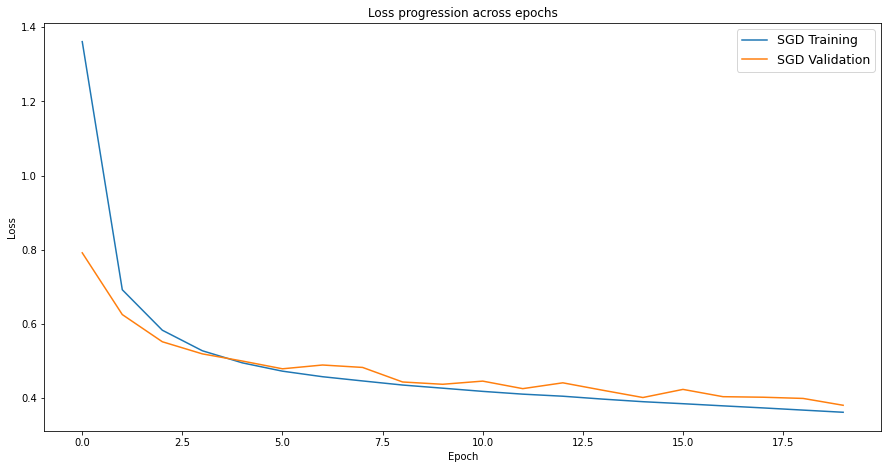

In [27]:
# Plot loss progression
plt.figure(figsize=(15,7.5))
plt.plot(SGD_train_losses, label='SGD Training')
plt.plot(SGD_valid_losses, label='SGD Validation')

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend(loc='best', fontsize=12.5)
plt.title("Loss progression across epochs")



     

In [28]:
# train for 20 epochs
### SGD momentum

optimizer = optimizer_SGD_momentum

SGD_momentum_train_losses, SGD_momentum_valid_losses, SGD_momentum_valid_accs = fit(
    model=model, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=model, test_dataloader=test_dataloader, device=DEVICE)




Epoch 0: Train Loss=0.3986, Validation Loss=0.4130, Validation acc=85.0700
Epoch 1: Train Loss=0.3608, Validation Loss=0.3822, Validation acc=86.2300
Epoch 2: Train Loss=0.3366, Validation Loss=0.3720, Validation acc=86.5100
Epoch 3: Train Loss=0.3193, Validation Loss=0.3499, Validation acc=87.4500
Epoch 4: Train Loss=0.3055, Validation Loss=0.3318, Validation acc=87.9400
Epoch 5: Train Loss=0.2928, Validation Loss=0.3346, Validation acc=87.9700
Epoch 6: Train Loss=0.2834, Validation Loss=0.3396, Validation acc=87.6700
Epoch 7: Train Loss=0.2737, Validation Loss=0.3209, Validation acc=88.3100
Epoch 8: Train Loss=0.2647, Validation Loss=0.3235, Validation acc=88.3700
Epoch 9: Train Loss=0.2554, Validation Loss=0.3556, Validation acc=86.7400
Epoch 10: Train Loss=0.2507, Validation Loss=0.3292, Validation acc=88.3700
Epoch 11: Train Loss=0.2414, Validation Loss=0.3184, Validation acc=88.7300
Epoch 12: Train Loss=0.2358, Validation Loss=0.3269, Validation acc=88.5700
Epoch 13: Train Loss=0

(0.3523254682736238, tensor(87.9900, device='cuda:0'))

Text(0.5, 1.0, 'Loss progression across epochs')

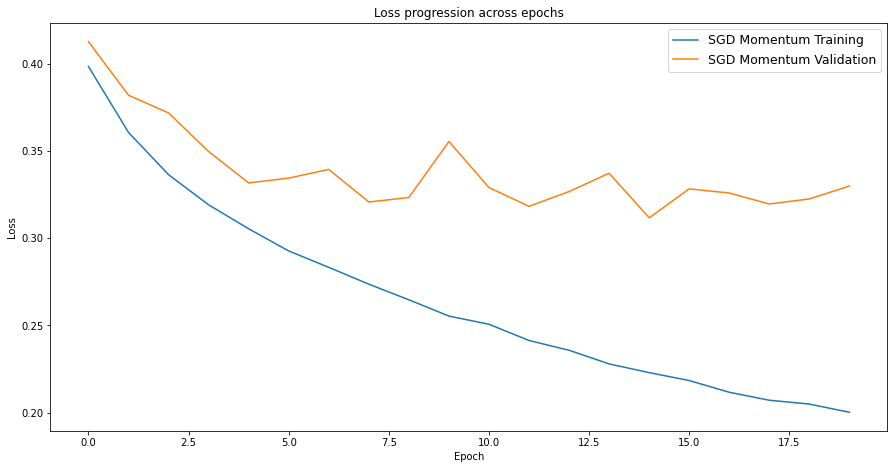

In [29]:
# Plot loss progression
plt.figure(figsize=(15,7.5))
plt.plot(SGD_momentum_train_losses, label='SGD Momentum Training')
plt.plot(SGD_momentum_valid_losses, label='SGD Momentum Validation')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend(loc='best', fontsize=12.5)
plt.title("Loss progression across epochs")



In [30]:
# train for 20 epochs
### ADAM

optimizer = optimizer_ADAM

ADAM_train_losses, ADAM_valid_losses, ADAM_valid_accs = fit(
    model=model, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=model, test_dataloader=test_dataloader, device=DEVICE)




Epoch 0: Train Loss=0.4916, Validation Loss=0.4250, Validation acc=84.3100
Epoch 1: Train Loss=0.4193, Validation Loss=0.4033, Validation acc=85.8300
Epoch 2: Train Loss=0.3960, Validation Loss=0.4245, Validation acc=85.6500
Epoch 3: Train Loss=0.3893, Validation Loss=0.4094, Validation acc=85.9600
Epoch 4: Train Loss=0.3769, Validation Loss=0.4291, Validation acc=84.9500
Epoch 5: Train Loss=0.3797, Validation Loss=0.4036, Validation acc=86.2000
Epoch 6: Train Loss=0.3692, Validation Loss=0.3963, Validation acc=86.8600
Epoch 7: Train Loss=0.3587, Validation Loss=0.4342, Validation acc=83.9800
Epoch 8: Train Loss=0.3506, Validation Loss=0.4129, Validation acc=86.1300
Epoch 9: Train Loss=0.3612, Validation Loss=0.4335, Validation acc=85.2100
Epoch 10: Train Loss=0.3443, Validation Loss=0.4094, Validation acc=85.8500
Epoch 11: Train Loss=0.3472, Validation Loss=0.4349, Validation acc=86.1400
Epoch 12: Train Loss=0.3383, Validation Loss=0.3810, Validation acc=87.0600
Epoch 13: Train Loss=0

(0.4612842569355853, tensor(85.0300, device='cuda:0'))

Text(0.5, 1.0, 'Loss progression across epochs')

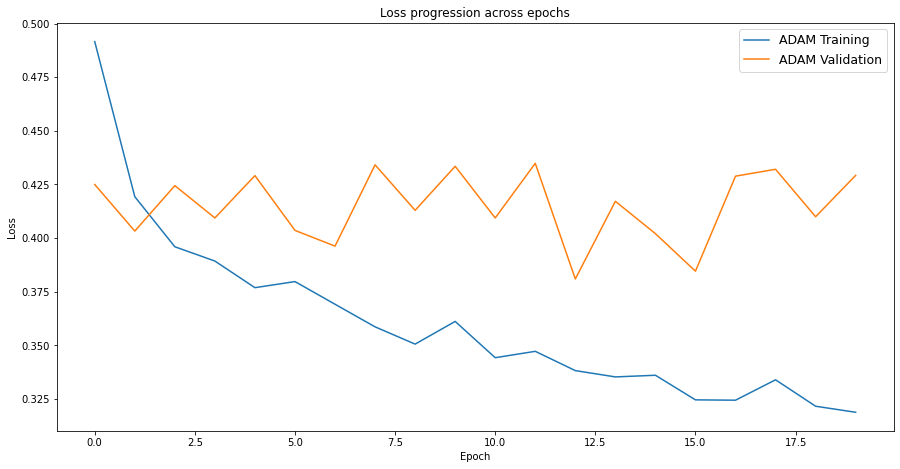

In [31]:
# Plot loss progression
plt.figure(figsize=(15,7.5))
plt.plot(ADAM_train_losses, label='ADAM Training')
plt.plot(ADAM_valid_losses, label='ADAM Validation')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend(loc='best', fontsize=12.5)
plt.title("Loss progression across epochs")

In [32]:
# train for 20 epochs
### ADAM with LR = 1

optimizer = optimizer_ADAM_1

ADAM_1_train_losses, ADAM_1_valid_losses, ADAM_1_valid_accs = fit(
    model=model, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=model, test_dataloader=test_dataloader, device=DEVICE)




Epoch 0: Train Loss=18.6432, Validation Loss=2.3449, Validation acc=9.7400
Epoch 1: Train Loss=2.3833, Validation Loss=2.4024, Validation acc=9.8500
Epoch 2: Train Loss=2.3829, Validation Loss=2.3629, Validation acc=10.7400
Epoch 3: Train Loss=2.3796, Validation Loss=2.4035, Validation acc=9.4500
Epoch 4: Train Loss=2.3871, Validation Loss=2.3640, Validation acc=9.7900
Epoch 5: Train Loss=2.3853, Validation Loss=2.3718, Validation acc=9.7400
Epoch 6: Train Loss=2.3811, Validation Loss=2.4188, Validation acc=10.7400
Epoch 7: Train Loss=2.3857, Validation Loss=2.4184, Validation acc=9.7400
Epoch 8: Train Loss=2.3837, Validation Loss=2.3569, Validation acc=9.9900
Epoch 9: Train Loss=2.3892, Validation Loss=2.3894, Validation acc=10.3200
Epoch 10: Train Loss=2.3829, Validation Loss=2.3526, Validation acc=9.8500
Epoch 11: Train Loss=2.3808, Validation Loss=2.3580, Validation acc=9.7900
Epoch 12: Train Loss=2.3805, Validation Loss=2.4138, Validation acc=9.7400
Epoch 13: Train Loss=2.3902, Va

(2.394998328590393, tensor(10., device='cuda:0'))

Text(0.5, 1.0, 'Loss progression across epochs')

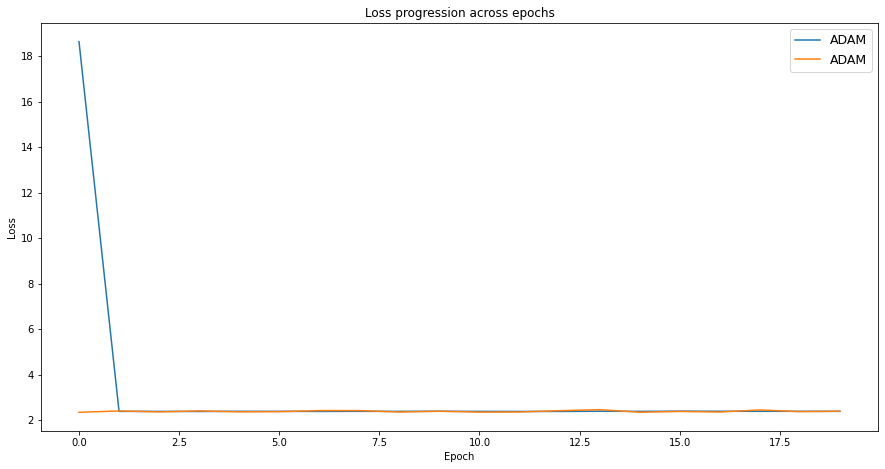

In [33]:
# Plot loss progression
plt.figure(figsize=(15,7.5))
plt.plot(ADAM_1_train_losses, label='ADAM')
plt.plot(ADAM_1_valid_losses, label='ADAM')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend(loc='best', fontsize=12.5)
plt.title("Loss progression across epochs")


Plot the training and validation learning curves (loss against steps and epochs) on a single plot.

Text(0.5, 1.0, 'Loss progression across epochs')

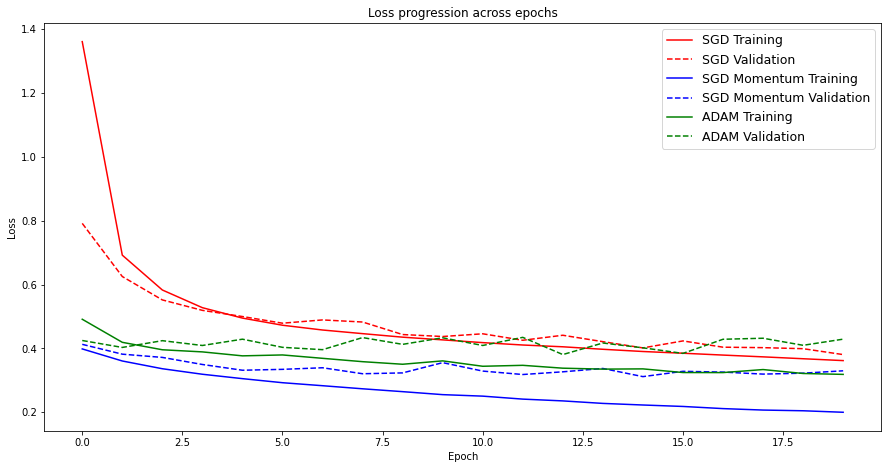

In [34]:
#for losses in tab_losses:
plt.figure(figsize=(15,7.5))

plt.plot(SGD_train_losses, '-r', label='SGD Training')
plt.plot(SGD_valid_losses, '--r', label='SGD Validation')
plt.plot(SGD_momentum_train_losses, '-b', label='SGD Momentum Training')
plt.plot(SGD_momentum_valid_losses, '--b',label='SGD Momentum Validation')
plt.plot(ADAM_train_losses, '-g', label='ADAM Training')
plt.plot(ADAM_valid_losses, '--g', label='ADAM Validation')
#plt.plot(ADAM_1_train_losses, label='ADAM with LR=1 Training')
#plt.plot(ADAM_1_valid_losses, label='ADAM with LR=1 Validation')


plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend(loc='best', fontsize=12.5)
plt.title("Loss progression across epochs")



     

As observed, SGD with momentum is able to reach the highest accuracy, followed by ADAM with the learning rate 0.01. And as we increase the learning rate to 1, the accuracy decreases to 10% from almost 85%. This proves the importance of learning rate and the choice of optimizer.

###3 Convolutional Neural Network (CNN)

A CNN with three convolutional layers (kernel size=3) and 16, 32, and 64 channels, respectively; a non-linearity and one max-pooling layer (kernel size=2) after every convolution; and a final fully connected layer.

In [35]:
class CNN(nn.Module): 
    def __init__(self):
        super().__init__()
        # define a CNN with 3 convolutional layers, followed by ReLU and Maxpool each, 
        # and a fully connected layer at the end.
        # We use a Sequential so the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=3, 
                stride=1, 
                padding=2), 
  
            nn.ReLU(),         
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(
                in_channels=32, 
                out_channels=64, 
                kernel_size=3, 
                stride=1, 
                padding=2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2) 
        )
         
              
        # fully connected layer, output 10 classes
        self.out = nn.Linear(64 * 5 * 5, 10)   
        
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)       
        x = self.out(x)
        return x   
        


In [36]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizers

CNN_optimizer_SGD = optim.SGD(cnn.parameters(), lr=LEARNING_RATE)

CNN_optimizer_SGD_momentum = optim.SGD(cnn.parameters(), lr=LEARNING_RATE, momentum=0.9, nesterov=True)

CNN_optimizer_ADAM = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

CNN_optimizer_ADAM_1 = optim.Adam(cnn.parameters(), lr=1)


Train this model with the same four configurations as before.

In [37]:
# train for 20 epochs
### SGD

optimizer = CNN_optimizer_SGD

CNN_SGD_train_losses, CNN_SGD_valid_losses, CNN_SGD_valid_accs = fit(
    model=cnn, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)


Epoch 0: Train Loss=1.3644, Validation Loss=0.8325, Validation acc=67.7400
Epoch 1: Train Loss=0.6817, Validation Loss=0.6005, Validation acc=78.8800
Epoch 2: Train Loss=0.5653, Validation Loss=0.6273, Validation acc=77.9100
Epoch 3: Train Loss=0.4985, Validation Loss=0.4814, Validation acc=82.5100
Epoch 4: Train Loss=0.4579, Validation Loss=0.4606, Validation acc=83.3900
Epoch 5: Train Loss=0.4317, Validation Loss=0.4334, Validation acc=84.4400
Epoch 6: Train Loss=0.4121, Validation Loss=0.4492, Validation acc=83.9500
Epoch 7: Train Loss=0.3946, Validation Loss=0.4153, Validation acc=85.5600
Epoch 8: Train Loss=0.3801, Validation Loss=0.3896, Validation acc=86.1900
Epoch 9: Train Loss=0.3704, Validation Loss=0.3932, Validation acc=85.9000
Epoch 10: Train Loss=0.3604, Validation Loss=0.3750, Validation acc=86.2500
Epoch 11: Train Loss=0.3515, Validation Loss=0.3595, Validation acc=87.2900
Epoch 12: Train Loss=0.3456, Validation Loss=0.3841, Validation acc=86.1400
Epoch 13: Train Loss=0

(0.33812708048671486, tensor(87.8400, device='cuda:0'))

Text(0.5, 1.0, 'Loss progression across epochs')

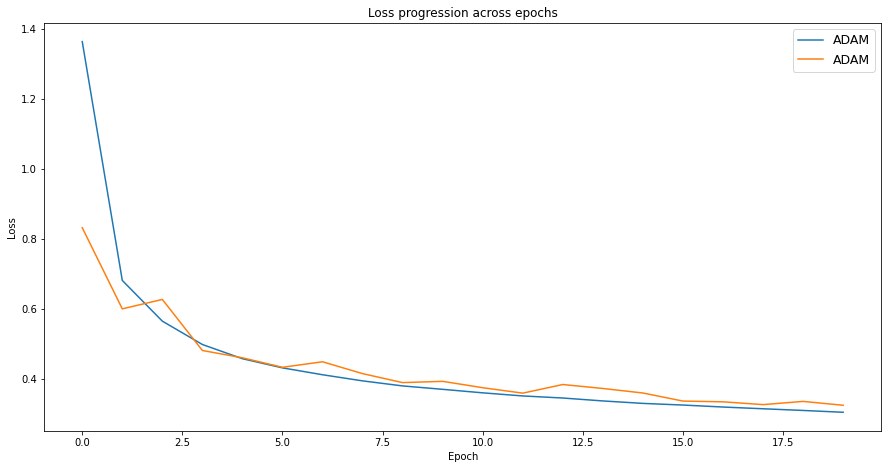

In [38]:
# Plot loss progression
plt.figure(figsize=(15,7.5))
plt.plot(CNN_SGD_train_losses, label='ADAM')
plt.plot(CNN_SGD_valid_losses, label='ADAM')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend(loc='best', fontsize=12.5)
plt.title("Loss progression across epochs")

In [39]:
# train for 20 epochs
### SGD momentum

optimizer = CNN_optimizer_SGD_momentum

CNN_SGD_momentum_train_losses, CNN_SGD_momentum_valid_losses, CNN_SGD_momentum_valid_accs = fit(
    model=cnn, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)


Epoch 0: Train Loss=0.3485, Validation Loss=0.3367, Validation acc=88.2800
Epoch 1: Train Loss=0.3104, Validation Loss=0.3151, Validation acc=88.8300
Epoch 2: Train Loss=0.2866, Validation Loss=0.2872, Validation acc=89.7500
Epoch 3: Train Loss=0.2703, Validation Loss=0.2999, Validation acc=89.5800
Epoch 4: Train Loss=0.2534, Validation Loss=0.2718, Validation acc=90.5300
Epoch 5: Train Loss=0.2430, Validation Loss=0.2641, Validation acc=90.4600
Epoch 6: Train Loss=0.2306, Validation Loss=0.2907, Validation acc=89.8300
Epoch 7: Train Loss=0.2237, Validation Loss=0.2565, Validation acc=90.8900
Epoch 8: Train Loss=0.2149, Validation Loss=0.2443, Validation acc=91.4200
Epoch 9: Train Loss=0.2068, Validation Loss=0.2535, Validation acc=91.2500
Epoch 10: Train Loss=0.2009, Validation Loss=0.2405, Validation acc=91.3700
Epoch 11: Train Loss=0.1931, Validation Loss=0.2574, Validation acc=91.0800
Epoch 12: Train Loss=0.1885, Validation Loss=0.2385, Validation acc=91.6300
Epoch 13: Train Loss=0

(0.2837907273533754, tensor(90.2400, device='cuda:0'))

Text(0.5, 1.0, 'Loss progression across epochs')

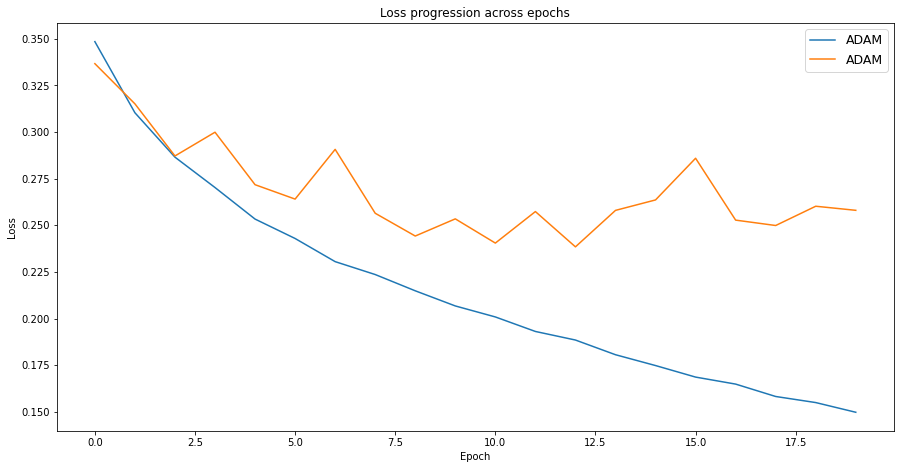

In [40]:
# Plot loss progression
plt.figure(figsize=(15,7.5))
plt.plot(CNN_SGD_momentum_train_losses, label='ADAM')
plt.plot(CNN_SGD_momentum_valid_losses, label='ADAM')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend(loc='best', fontsize=12.5)
plt.title("Loss progression across epochs")

In [41]:
# train for 20 epochs
### ADAM


optimizer = CNN_optimizer_ADAM

CNN_ADAM_train_losses, CNN_ADAM_valid_losses, CNN_ADAM_valid_accs = fit(
    model=cnn, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)



Epoch 0: Train Loss=0.3509, Validation Loss=0.3427, Validation acc=87.7000
Epoch 1: Train Loss=0.3256, Validation Loss=0.3434, Validation acc=88.1700
Epoch 2: Train Loss=0.3094, Validation Loss=0.3523, Validation acc=87.2400
Epoch 3: Train Loss=0.3072, Validation Loss=0.3255, Validation acc=88.6700
Epoch 4: Train Loss=0.3016, Validation Loss=0.3230, Validation acc=89.0000
Epoch 5: Train Loss=0.2955, Validation Loss=0.3286, Validation acc=88.6500
Epoch 6: Train Loss=0.2934, Validation Loss=0.3128, Validation acc=88.9200
Epoch 7: Train Loss=0.2930, Validation Loss=0.3367, Validation acc=88.5600
Epoch 8: Train Loss=0.2865, Validation Loss=0.3117, Validation acc=88.7300
Epoch 9: Train Loss=0.2811, Validation Loss=0.3301, Validation acc=88.1400
Epoch 10: Train Loss=0.2840, Validation Loss=0.3206, Validation acc=88.4200
Epoch 11: Train Loss=0.2843, Validation Loss=0.3393, Validation acc=88.1000
Epoch 12: Train Loss=0.2746, Validation Loss=0.3533, Validation acc=88.3000
Epoch 13: Train Loss=0

(0.3598448301929515, tensor(88.3200, device='cuda:0'))

Text(0.5, 1.0, 'Loss progression across epochs')

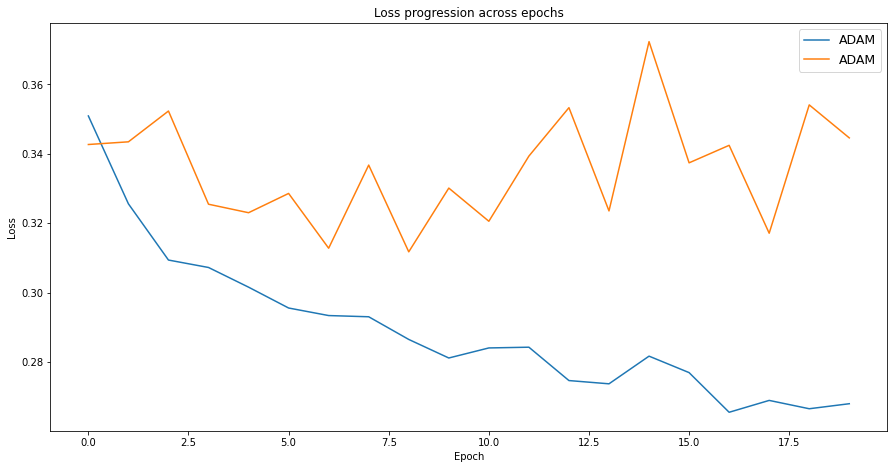

In [42]:
# Plot loss progression
plt.figure(figsize=(15,7.5))
plt.plot(CNN_ADAM_train_losses, label='ADAM')
plt.plot(CNN_ADAM_valid_losses, label='ADAM')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend(loc='best', fontsize=12.5)
plt.title("Loss progression across epochs")

In [ ]:
# train for 20 epochs
### ADAM with LR = 1


optimizer = CNN_optimizer_ADAM_1

CNN_ADAM_1_train_losses, CNN_ADAM_1_valid_losses, CNN_ADAM_1_valid_accs = fit(
    model=cnn, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)


Epoch 0: Train Loss=43.6542, Validation Loss=2.3518, Validation acc=10.7400
Epoch 1: Train Loss=2.3778, Validation Loss=2.3753, Validation acc=9.7400
Epoch 2: Train Loss=2.3880, Validation Loss=2.3563, Validation acc=9.5200
Epoch 3: Train Loss=2.3881, Validation Loss=2.3872, Validation acc=10.2700
Epoch 4: Train Loss=2.3831, Validation Loss=2.3528, Validation acc=9.7900
Epoch 5: Train Loss=2.3852, Validation Loss=2.3886, Validation acc=10.7400
Epoch 6: Train Loss=2.3888, Validation Loss=2.3836, Validation acc=9.5200
Epoch 7: Train Loss=2.3874, Validation Loss=2.4041, Validation acc=9.7400
Epoch 8: Train Loss=2.3862, Validation Loss=2.4106, Validation acc=10.3200
Epoch 9: Train Loss=2.3854, Validation Loss=2.4114, Validation acc=9.4500
Epoch 10: Train Loss=2.3913, Validation Loss=2.3506, Validation acc=9.8500
Epoch 11: Train Loss=2.3859, Validation Loss=2.3774, Validation acc=9.9900
Epoch 12: Train Loss=2.3923, Validation Loss=2.3507, Validation acc=9.9900
Epoch 13: Train Loss=2.3857, V

(2.3695917646408082, tensor(10., device='cuda:0'))

Text(0.5, 1.0, 'Loss progression across epochs')

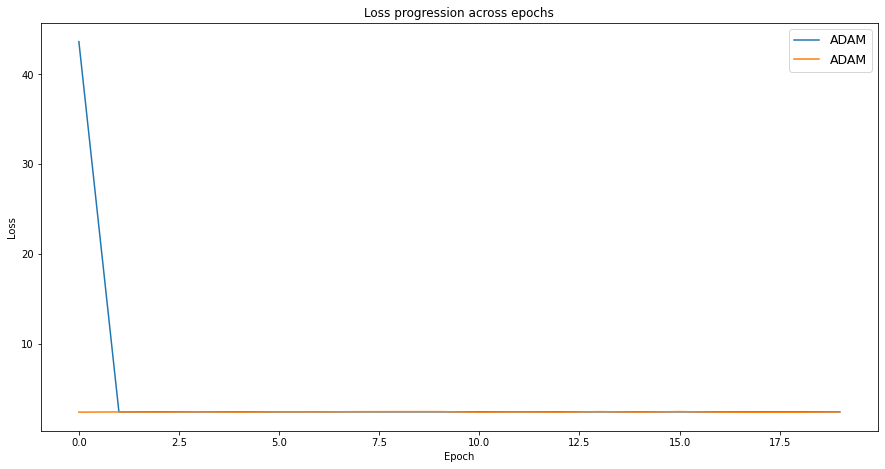

In [ ]:
# Plot loss progression
plt.figure(figsize=(15,7.5))
plt.plot(CNN_ADAM_1_train_losses, label='ADAM')
plt.plot(CNN_ADAM_1_valid_losses, label='ADAM')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend(loc='best', fontsize=12.5)
plt.title("Loss progression across epochs")

Plot the training and validation learning curves on a single plot.

Text(0.5, 1.0, 'Loss progression across epochs')

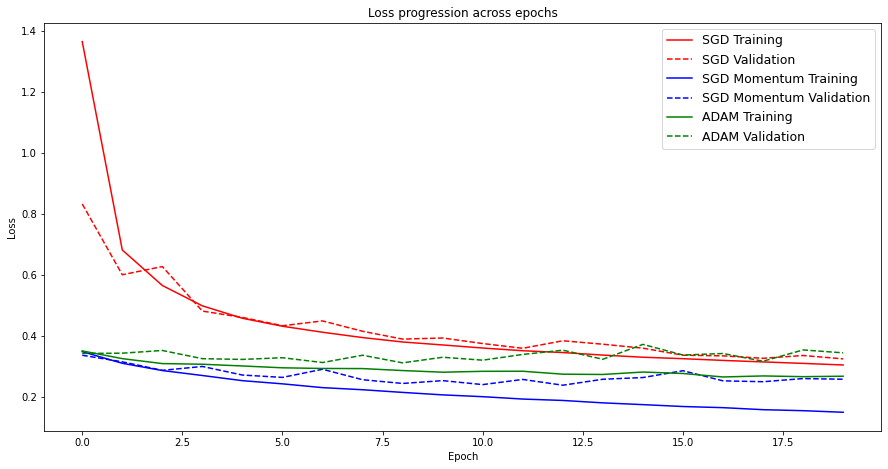

In [43]:
plt.figure(figsize=(15,7.5))

plt.plot(CNN_SGD_train_losses, '-r', label='SGD Training')
plt.plot(CNN_SGD_valid_losses, '--r', label='SGD Validation')
plt.plot(CNN_SGD_momentum_train_losses, '-b', label='SGD Momentum Training')
plt.plot(CNN_SGD_momentum_valid_losses, '--b',label='SGD Momentum Validation')
plt.plot(CNN_ADAM_train_losses, '-g', label='ADAM Training')
plt.plot(CNN_ADAM_valid_losses, '--g', label='ADAM Validation')
#plt.plot(CNN_ADAM_1_train_losses, label='ADAM with LR=1 Training')
#plt.plot(CNN_ADAM_1_valid_losses, label='ADAM with LR=1 Validation')


plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend(loc='best', fontsize=12.5)
plt.title("Loss progression across epochs")



As observed, SGD with momentum is able to reach the highest accuracy, followed by ADAM with the learning rate 0.01. And as we increase the learning rate to 1, the accuracy decreases to 10% from 90%. This proves the importance of learning rate and the choice of optimizer. 

How does the CNN perform compared to the MLP? As observed, CNN reaches higher accuracy and lower average loss for all optimizer configurations. This therefore also proves importance of choice of model.

###4  Number of Parameters

Create a function that computes the number of parameters of a given model. 

In [44]:
def count_params(model):
  count = 0
  for param in model.parameters():
    count = count + param.numel()
  return count


Show the number of parameters for the two models you have used. 

In [45]:
num_params_mlp = count_params(model)
num_params_cnn = count_params(cnn)

print('MLP number of parameters: ', num_params_mlp)
print('CNN number of parameters: ', num_params_cnn)

MLP number of parameters:  89610
CNN number of parameters:  39306


As seen, MLP uses more parameters but it achieves lower performance than CNN. Therefore, more parameters does not translate to better performance.

###5

PermutedFashionMNIST1 : In this version of the dataset, the pixels are randomly permuted. Visualize the new dataset. Train one MLP and one CNN using SGD with momentum lr=0.01, momentum=0.9, nesterov=True). What do you ob- serve ? Is one model more affected than the other ? Explain.

In [46]:
# Define the random permutation
class RandomPermutation(object):
  def __init__(self, num_features):
    self.num_features = num_features 
    self.reindex = torch.randperm(num_features)
  def __call__(self, img):
    assert self.num_features == img.numel()
    orig_shape = img.shape
    img = img.view(-1)[self.reindex].view(orig_shape)
    return img

In [47]:
# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform" and also random permutation transform
transform = T.Compose([
    T.ToTensor(),
    RandomPermutation(28*28*1)
])


# load the train dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

print(train_dataset)

# Split the training set into training + validation. 
# How many samples does the training set have?
print(f"The training set has {len(train_dataset)} samples.")

# Split the dataset into ?????-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset, 
    lengths=[50000, 10000], 
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)



Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
The training set has 60000 samples.


In [48]:
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)


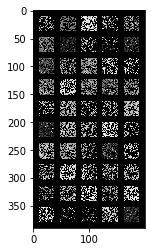

In [49]:


import matplotlib.pyplot as plt
import numpy as np

# Get the first 50 000 images of the train dataset. Hint: use next(), iter()
images = next(iter(train_dataloader))[0][:50000]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

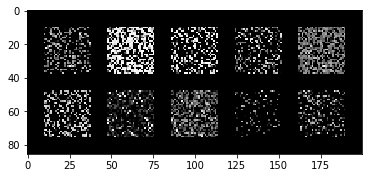

In [50]:
# Get the first 10 000 images of the validation dataset. Hint: use next(), iter()
images = next(iter(test_dataloader))[0][:10000]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)


In [51]:
# initialize the model for MLP
model = Net()

# move model to device
model = model.to(DEVICE)

# define the optimizer
optimizer_SGD_momentum = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

In [52]:
# Train for 20 epochs with MLP

optimizer = optimizer_SGD_momentum

SGD_momentum_train_losses, SGD_momentum_valid_losses, SGD_momentum_valid_accs = fit(
    model=model, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=model, test_dataloader=test_dataloader, device=DEVICE)




Epoch 0: Train Loss=0.6730, Validation Loss=0.4552, Validation acc=84.3200
Epoch 1: Train Loss=0.4338, Validation Loss=0.4080, Validation acc=85.0000
Epoch 2: Train Loss=0.3830, Validation Loss=0.3681, Validation acc=87.0700
Epoch 3: Train Loss=0.3575, Validation Loss=0.3676, Validation acc=86.9800
Epoch 4: Train Loss=0.3329, Validation Loss=0.3416, Validation acc=87.5500
Epoch 5: Train Loss=0.3180, Validation Loss=0.3463, Validation acc=87.6700
Epoch 6: Train Loss=0.3046, Validation Loss=0.3231, Validation acc=88.3000
Epoch 7: Train Loss=0.2961, Validation Loss=0.3337, Validation acc=88.1100
Epoch 8: Train Loss=0.2832, Validation Loss=0.3221, Validation acc=88.3200
Epoch 9: Train Loss=0.2713, Validation Loss=0.3201, Validation acc=88.4500
Epoch 10: Train Loss=0.2644, Validation Loss=0.3440, Validation acc=87.3800
Epoch 11: Train Loss=0.2560, Validation Loss=0.3359, Validation acc=88.3500
Epoch 12: Train Loss=0.2487, Validation Loss=0.3364, Validation acc=87.8700
Epoch 13: Train Loss=0

(0.3433548112878576, tensor(87.9400, device='cuda:0'))

In [53]:
# initialize model to CNN
cnn = CNN().to(DEVICE)

# define the optimizer. 
CNN_optimizer_SGD_momentum = optim.SGD(cnn.parameters(), lr=LEARNING_RATE, momentum=0.9, nesterov=True)

In [54]:
# Train for 20 epochs with CNN 

optimizer = CNN_optimizer_SGD_momentum

CNN_SGD_momentum_train_losses, CNN_SGD_momentum_valid_losses, CNN_SGD_momentum_valid_accs = fit(
    model=cnn, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)


Epoch 0: Train Loss=0.8815, Validation Loss=0.5052, Validation acc=82.0700
Epoch 1: Train Loss=0.4533, Validation Loss=0.4279, Validation acc=85.0400
Epoch 2: Train Loss=0.3979, Validation Loss=0.3920, Validation acc=85.8500
Epoch 3: Train Loss=0.3635, Validation Loss=0.3725, Validation acc=87.0100
Epoch 4: Train Loss=0.3382, Validation Loss=0.3557, Validation acc=87.1100
Epoch 5: Train Loss=0.3195, Validation Loss=0.3550, Validation acc=87.3000
Epoch 6: Train Loss=0.3035, Validation Loss=0.3525, Validation acc=87.3700
Epoch 7: Train Loss=0.2870, Validation Loss=0.3643, Validation acc=86.8700
Epoch 8: Train Loss=0.2739, Validation Loss=0.3523, Validation acc=87.2800
Epoch 9: Train Loss=0.2637, Validation Loss=0.3683, Validation acc=87.1400
Epoch 10: Train Loss=0.2497, Validation Loss=0.3411, Validation acc=87.5500
Epoch 11: Train Loss=0.2414, Validation Loss=0.3549, Validation acc=87.8200
Epoch 12: Train Loss=0.2335, Validation Loss=0.3629, Validation acc=87.5600
Epoch 13: Train Loss=0

(0.45487694856845773, tensor(86.3000, device='cuda:0'))

MLP reaches almost the same accuracy as non-permutated. CNN however, is more affected than MLP and it doesn't yield as accurate results compared to non-permutated.

##Part 3: Multi-Task Learning with MultiMNIST

### 1 Create a new sample.

Implement the function make new sample(x1: torch.Tensor, x2: torch.Tensor) -> torch.TensorthattakestwoMNISTsamples and creates a new MultiMNIST sample. An example is shown in figure 1b. You can use the following procedure :
— Create an empty tensor of size 36 × 36
— Place one image on the top-left corner. Reminder : A MultiMNIST image has
dimensions 28 × 28.
— Place the other image on the bottom-right corner. For the overlapping pixels take
the max value.
Visualize five samples with corresponding labels.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

In [ ]:

# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform" 
transform = T.Compose([
    T.ToTensor()
])

# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

print(train_dataset)




Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [ ]:
# define the hyperparameters
BATCH_SIZE = 50
TEST_BATCH_SIZE = 10
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)


cuda


In [ ]:
# Combine 2 images
def make_new_sample(x1: torch.Tensor, x2: torch.Tensor):
  # Create an empty tensor of size 36 × 36
  sample_new = torch.zeros(1, 36, 36)
  #Place one image on the top-left corner. 
  # For the overlapping pixels take the max value.
  #A MultiMNIST image has dimensions 28 × 28.
  sample_new[0, :28, :28]= torch.max(sample_new[0, :28, :28], x1)
  # Place the other image on the bottom-right corner. 
  # For the overlapping pixels take the max value.
  sample_new[0, 8:, 8:]= torch.max(sample_new[0, 8:, 8:], x2)
  return sample_new

  

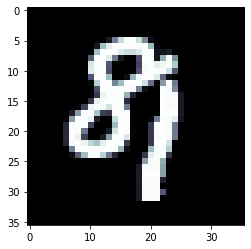

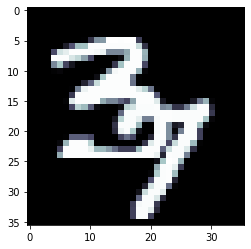

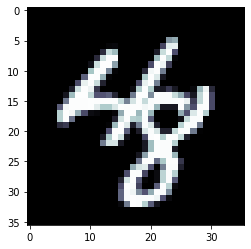

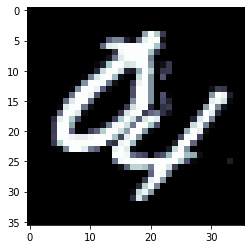

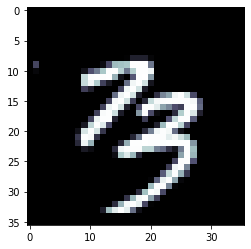

In [ ]:
# Visualize 5 samples 
import matplotlib.pyplot as plt
import random

labels1= []
labels2 = []
for i in range (0,5):
  z1, label1 =train_dataset[random.randrange(0, 1000, 1)]
  z2, label2 = train_dataset[random.randrange(0, 1000, 1)]
  z12 = make_new_sample(z1, z2)
  labels1.append(label1)


  plt.figure()
  plt.imshow(z12.squeeze(),cmap='bone')
  

### 2 Create the new dataset.

Repeat the above procedure 60000 and 10000 times to create the full train and test datasets, respectively. The MultiMNIST train images must be created by samples of the MNIST train dataset. Similarly, for the test dataset. Hint : Use TensorDataset to store the images and their labels.

In [ ]:
# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform" 

train_dataset_mult = []
train_labels1 = []
train_labels2 = []

for i in range (0,60000):
  z1, label1 =train_dataset[random.randrange(0, (60000-1), 1)]
  z2, label2 = train_dataset[random.randrange(0,(60000-1), 1)]
  z12 = make_new_sample(z1, z2)
  train_labels1.append(label1)
  train_labels2.append(label2)
  #plt.figure()
  #plt.imshow(z12.squeeze(),cmap='bone')
  train_dataset_mult.append(z12)

# what is the type of the "new" training dataset?
#print(train_dataset_mult)

The training set has 60000 samples.
9


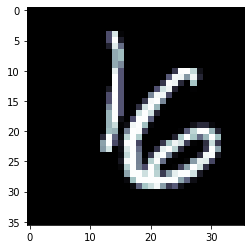

In [ ]:
plt.figure()
plt.imshow(train_dataset_mult[30].squeeze(),cmap='bone')

print(f"The training set has {len(train_dataset_mult)} samples.")
print(train_labels1[8])

In [ ]:
# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform" 

valid_dataset_mult = []

labels_test1 = []
labels_test2 = []
for i in range (0,10000):
  z1, label1 =train_dataset[random.randrange(0, (60000-1), 1)]
  z2, label2 = train_dataset[random.randrange(0,(60000-1), 1)]
  z12 = make_new_sample(z1, z2)
  labels_test1.append(label1)
  labels_test2.append(label2)
  #plt.figure()
  #plt.imshow(z12.squeeze(),cmap='bone')
  valid_dataset_mult.append(z12)

# what is the type of the "new" training dataset?
#print(train_dataset_mult)

The test set has 10000 samples.


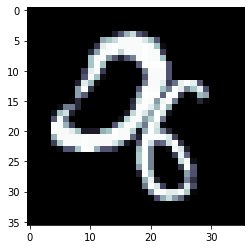

In [ ]:
plt.figure()
plt.imshow(valid_dataset_mult[30].squeeze(),cmap='bone')

print(f"The test set has {len(valid_dataset_mult)} samples.")

In [ ]:
print(f"The training set has {len(train_dataset_mult)} samples.")
print(f"The test set has {len(valid_dataset_mult)} samples.")


The training set has 60000 samples.
The test set has 10000 samples.


In [ ]:
test_labels1 = torch.tensor(labels_test1)
test_labels2 = torch.tensor(labels_test2)
test_datas = torch.stack(valid_dataset_mult)
test_dataset_new = torch.utils.data.TensorDataset(test_datas, test_labels1, test_labels2)

train_labels1 = torch.tensor(train_labels1)
train_labels2 = torch.tensor(train_labels2)
train_datas = torch.stack(train_dataset_mult)
train_dataset_new = torch.utils.data.TensorDataset(train_datas, train_labels1, train_labels2)


In [ ]:
train_dataset_new[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]), tensor(6), tensor(7))

In [ ]:
train_dataloader = DataLoader(
    dataset=train_dataset_new, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=test_dataset_new, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)



###3 Create the Multi-Task model. 

Adapt the Convolutional Neural Network seen in class to have two outputs by implementing the model in figure 1c. The encoder has two convolutional layers of 10 and 20 channels, respectively, and a Linear layer with 50 output features. Each convolutional layer has kernel size of 5 and is followed by ReLU and Maxpool. Each decoder is a linear layer.


In [ ]:
class CNN(nn.Module): 
    def __init__(self):
        super().__init__()
        # define a CNN with 
        # for encoder, 2 convolutional layers, followed by ReLU and Maxpool each, and one linear layer.
        # and a fully connected layer at the end.
        # 2 decoders
        # for each decoder, a linear layer, fully connected. 

        self.conv = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=10,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(
                in_channels=10, 
                out_channels=20, 
                kernel_size=5, 
                stride=1, 
                padding=2), 
  
            nn.ReLU(),         
            nn.MaxPool2d(kernel_size=2)
            )
        
        self.lin = nn.Linear(1620, 50)   
        self.re = nn.ReLU()
        self.out1 = nn.Linear(50, 10) 
        self.out2 = nn.Linear(50, 10) 


        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)       
        x = self.lin(x)
        x = self.re(x)
        y1 = self.out1(x)
        y2 = self.out2(x)
        return y1, y2
        


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader


def train_epoch(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
):
    """
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    """

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target1, target2) in enumerate(train_dataloader):
        # move data and target to device
        target1 = target1.type(torch.LongTensor)

        target2 = target2.type(torch.LongTensor)
        data, target1, target2 = data.to(device), target1.to(device), target2.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output1, output2 = model(data)

        # compute the loss, take average of loss 1 and 2
        calc_loss = nn.CrossEntropyLoss()
        loss1 = calc_loss(output1, target1)
        loss2 = calc_loss(output2, target2)
        loss = (loss1+loss2)/2


        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    return running_loss / len(train_dataloader)

from typing import Optional

def fit(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    epochs: int, 
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a 
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs1 = []
    valid_accs2 = []
    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model, 
            train_dataloader=train_dataloader, 
            optimizer=optimizer, 
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            valid_loss, valid_acc1, valid_acc2 = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs1.append(valid_acc1)
            valid_accs2.append(valid_acc2)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, First digit Validation acc={valid_acc1:.4f}, Second digit Validation acc={valid_acc2:.4f}")

    return train_losses, valid_losses, valid_acc1, valid_acc2



def predict(model: nn.Module, test_dataloader: DataLoader, device: torch.device, verbose=True):
    model.eval()
    test_loss = 0
    correct1 = 0
    correct2 = 0
    with torch.no_grad():
        for data, target1, target2 in test_dataloader:
            data, target1, target2 = data.to(device), target1.to(device), target2.to(device)
                    
            output1, output2 = model(data)

            loss1 = F.cross_entropy(output1, target1)
            loss2 = F.cross_entropy(output2, target2)
            loss = (loss1+loss2)/2

            test_loss += loss.item()
            pred1 = output1.data.max(1, keepdim=True)[1]
            correct1 += pred1.eq(target1.data.view_as(pred1)).sum()

            pred2 = output2.data.max(1, keepdim=True)[1]
            correct2 += pred2.eq(target2.data.view_as(pred2)).sum()



    test_loss /= len(test_dataloader.dataset)
    accuracy1 = 100.0 * correct1 / len(test_dataloader.dataset)

    accuracy2 = 100.0 * correct2 / len(test_dataloader.dataset)

    if verbose:
        print(
            f"Test set: Avg. loss: {test_loss:.4f}, Accuracy of first digit: {correct1}/{len(test_dataloader.dataset)} ({accuracy1:.0f}%), Accuracy of second digit: {correct2}/{len(test_dataloader.dataset)} ({accuracy2:.0f}%)"
        )

    return test_loss, accuracy1, accuracy2


def visualize_images(dataloader):
    images = next(iter(dataloader))[0][:10]
    grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

    def show(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")

    show(grid)

###4 Train the Multi-Task model. 

Train the multi-task model and report the accuracy and loss per task. Use the average of task losses as your objective. Hint : Adapt the training and predict functions seen in class to handle two predictions, two losses etc.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer. Use SGD momentum

CNN_optimizer_SGD_momentum = optim.SGD(cnn.parameters(), lr=LEARNING_RATE, momentum=0.9, nesterov=True)

In [ ]:
#SGD momentum

optimizer = CNN_optimizer_SGD_momentum

train_losses, valid_losses, valid_accs_dig1, validaccs_dig2 = fit(
    model=cnn, 
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

# define the hyperparameters
BATCH_SIZE = 1000
TEST_BATCH_SIZE = 1000
LEARNING_RATE = 0.01

Epoch 0: Train Loss=0.4540, Validation Loss=0.0153, First digit Validation acc=95.7500, Second digit Validation acc=94.5500
Epoch 1: Train Loss=0.1354, Validation Loss=0.0125, First digit Validation acc=96.2600, Second digit Validation acc=95.6600
Epoch 2: Train Loss=0.0997, Validation Loss=0.0095, First digit Validation acc=97.2900, Second digit Validation acc=96.4900
Epoch 3: Train Loss=0.0781, Validation Loss=0.0081, First digit Validation acc=97.6100, Second digit Validation acc=97.0200
Epoch 4: Train Loss=0.0646, Validation Loss=0.0099, First digit Validation acc=97.3100, Second digit Validation acc=96.4100
Epoch 5: Train Loss=0.0552, Validation Loss=0.0081, First digit Validation acc=97.8800, Second digit Validation acc=96.9800
Epoch 6: Train Loss=0.0477, Validation Loss=0.0069, First digit Validation acc=97.9400, Second digit Validation acc=97.5900
Epoch 7: Train Loss=0.0402, Validation Loss=0.0074, First digit Validation acc=97.9200, Second digit Validation acc=97.4200
Epoch 8: